In [1]:
import tensorflow as tf
import numpy as np
import re
import pandas as pd
import matplotlib.pyplot as plt


INPUT_DIMS = (50, 55, 1)
REGION_SIZES = [2,3,4,5,6,7,8]
FILTERS_PER_REGION = 16



In [2]:
names = ['TweetID', 'Sentiment', 'Tweet']

train = pd.read_csv('../input/aggregatetweets/aggregate.csv', names=names, engine='python')


In [3]:
def remove_pattern(input_txt, pattern):
  r = re.findall(pattern, input_txt)
  for i in r:
    input_txt = re.sub(i, '', input_txt)        
  return input_txt



In [4]:
def clean_tweets(frame, column_name):
  frame = frame.drop_duplicates().reset_index(drop=True) #remove duplicate rows
  frame['Tweet_Clean_Text'] = np.vectorize(remove_pattern)(frame[column_name], "RT @[\w]*:") #remove twitter return handle
  frame.Tweet_Clean_Text = np.vectorize(remove_pattern)(frame['Tweet_Clean_Text'], "@[\w]*") #remove twitter handle
  frame.Tweet_Clean_Text = np.vectorize(remove_pattern)(frame['Tweet_Clean_Text'], "https?://[A-Za-z0-9./]*") #remove URLs
  frame.Tweet_Clean_Text = frame.Tweet_Clean_Text.str.replace("[^a-zA-Z#]", " ") #remove special characters except for #
  frame.Tweet_Clean_Text = frame.Tweet_Clean_Text.replace('\s+', ' ', regex=True) #remove extra spaces in between words

  return frame

In [5]:
train = clean_tweets(train, 'Tweet')

vectorizer = tf.keras.preprocessing.text.Tokenizer()

vectorizer.fit_on_texts(train['Tweet_Clean_Text'])

https://medium.com/saarthi-ai/sentence-classification-using-convolutional-neural-networks-ddad72c7048c

In [6]:
x_train = vectorizer.texts_to_sequences(train['Tweet_Clean_Text'])
x_train = tf.keras.preprocessing.sequence.pad_sequences(x_train, padding='post', maxlen=INPUT_DIMS[1])

In [7]:
INPUT_DIM = x_train.shape[0]
x_train.shape

(49462, 55)

In [8]:
y_train = []
for sentiment in train['Sentiment']:
    if sentiment == 'positive':
        y_train.append([1,0,0])
    elif sentiment == 'negative':
        y_train.append([0,1,0])
    else:
        y_train.append([0,0,1])
y_train = np.array(y_train, dtype='int64')

https://stackoverflow.com/questions/43151775/how-to-have-parallel-convolutional-layers-in-keras

In [17]:
from tensorflow import keras as keras
from keras import backend as K

input_layer = tf.keras.Input(
    shape=INPUT_DIMS[1]
)

embedding_layer = tf.keras.layers.Embedding(
    input_dim=INPUT_DIM,
    output_dim=INPUT_DIMS[0],
)(input_layer)

parallel_layers = []
for size in REGION_SIZES:
    parallel_layer = tf.keras.layers.Reshape((INPUT_DIMS[0],INPUT_DIMS[1], INPUT_DIMS[2]))(embedding_layer)
    parallel_layer = tf.keras.layers.Conv2D(FILTERS_PER_REGION, (INPUT_DIMS[0], size), activation='relu')(parallel_layer)
    parallel_layer = tf.keras.layers.MaxPool2D(pool_size=(1,size))(parallel_layer)
    parallel_layers.append(parallel_layer)
merged = tf.keras.layers.concatenate(parallel_layers, axis=2)
flatten = tf.keras.layers.Flatten()(merged)
hidden = tf.keras.layers.Dense(FILTERS_PER_REGION * len(REGION_SIZES), activation='relu')(flatten)
hidden = tf.keras.layers.Dropout(0.25)(hidden)
output = tf.keras.layers.Dense(3, activation= 'softmax')(hidden)


model = tf.keras.Model(input_layer, output)

def recall_score(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    recall_score.__name__ = 'recall'
    return recall

def precision_score(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    precision_score.__name__ = 'precision'
    return precision

def f1_metrics(y_true, y_pred):
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1_metrics.__name__ = 'f1'
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

def f1_metrics(y_true, y_pred):
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1_metrics.__name__ = 'f1_score'
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

metrics = [
           keras.metrics.CategoricalAccuracy(),
           keras.metrics.Precision(name='precision'),
           keras.metrics.Recall(name='recall'),
           f1_metrics,
           #keras.metrics.TruePositives(name='tp'),
           #keras.metrics.FalsePositives(name='fp'),
           #keras.metrics.TrueNegatives(name='tn'),
           #keras.metrics.FalseNegatives(name='fn'),
]

model.compile(optimizer='adam',
              loss=keras.losses.CategoricalCrossentropy(),
              metrics=metrics)

history = model.fit(x_train,
                    y_train,
                    batch_size=500,
                    epochs=10,
                    validation_split=0.05,
                    shuffle=True
                   )

model.save('./')

Epoch 1/10
94/94 [==============================] - 4s 44ms/step - loss: 0.9934 - categorical_accuracy: 0.4711 - precision: 0.5813 - recall: 0.0740 - f1_metrics: 0.1191 - val_loss: 0.9290 - val_categorical_accuracy: 0.4927 - val_precision: 0.5576 - val_recall: 0.2583 - val_f1_metrics: 0.3529
Epoch 2/10
94/94 [==============================] - 3s 35ms/step - loss: 0.7394 - categorical_accuracy: 0.6558 - precision: 0.7137 - recall: 0.5581 - f1_metrics: 0.6244 - val_loss: 0.9069 - val_categorical_accuracy: 0.5582 - val_precision: 0.5850 - val_recall: 0.5020 - val_f1_metrics: 0.5409
Epoch 3/10
94/94 [==============================] - 3s 31ms/step - loss: 0.4623 - categorical_accuracy: 0.8183 - precision: 0.8406 - recall: 0.7907 - f1_metrics: 0.8148 - val_loss: 1.0594 - val_categorical_accuracy: 0.5489 - val_precision: 0.5644 - val_recall: 0.5210 - val_f1_metrics: 0.5423
Epoch 4/10
94/94 [==============================] - 3s 31ms/step - loss: 0.2573 - categorical_accuracy: 0.9098 - precisio

In [18]:
def plot_metrics(history):
  metrics = ['loss', 'categorical_accuracy', 'precision', 'recall', 'f1_metrics']
  for n, metric in enumerate(metrics):
    name = metric.replace("_"," ").capitalize()
    plt.subplot(2,3,n+1)
    plt.plot(history.epoch, history.history[metric], color=colors[0], label='Train')
    plt.plot(history.epoch, history.history['val_'+metric],
             color=colors[0], linestyle="--", label='Val')
    plt.xlabel('Epoch')
    plt.ylabel(name)
    if metric == 'loss':
      plt.ylim([0, plt.ylim()[1]])
    else:
      plt.ylim([0,1])

    plt.legend()

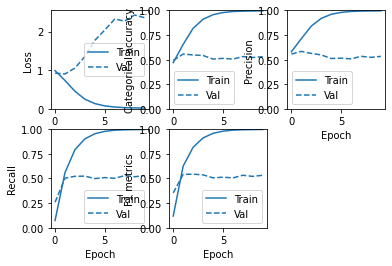

In [19]:
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
plot_metrics(history)